<a href="https://colab.research.google.com/github/anikch/Clustering-of-BBC-News-Articles/blob/main/Clustering_of_BBC_News_Articles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing required libraries
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#!pip install contractions
#!pip install pyclustertend

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import PlaintextCorpusReader
from nltk import FreqDist
from wordcloud import WordCloud, STOPWORDS

import re
import string
from collections import Counter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import SparsePCA, PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import contractions
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Data Pre-processing

In [ ]:
# unziping file
#!unzip /content/drive/MyDrive/colab_data/bbc.zip
!ls -lrth

total 28K
drwxr-xr-x 1 root root 4.0K Nov  1 13:35 sample_data
drwx------ 5 root root 4.0K Nov 18 21:15 drive
drwxr-xr-x 2 root root 4.0K Nov 18 21:15 business
drwxr-xr-x 2 root root 4.0K Nov 18 21:15 entertainment
drwxr-xr-x 2 root root 4.0K Nov 18 21:15 politics
drwxr-xr-x 2 root root 4.0K Nov 18 21:15 sport
drwxr-xr-x 2 root root 4.0K Nov 18 21:15 tech


In [ ]:
# Craeting corpus from text files
business_corpus= PlaintextCorpusReader('/content/business', '.*')
entertainment_corpus= PlaintextCorpusReader('/content/entertainment', '.*')
politics_corpus= PlaintextCorpusReader('/content/politics', '.*')
sport_corpus= PlaintextCorpusReader('/content/sport', '.*')
tech_corpus= PlaintextCorpusReader('/content/tech', '.*')
all_corpus= [business_corpus, entertainment_corpus, politics_corpus, sport_corpus, tech_corpus]

In [ ]:
# Creating function for corpus to list
def corpus_to_list(all_corpus):
  articles=[]
  for corpus in all_corpus:
    for file in corpus.fileids():
      articles.append(corpus.raw(fileids= file))
  return articles

In [ ]:
# Checking length
articles_list= corpus_to_list(all_corpus)
len(articles_list)

179

In [ ]:
# Creating dataframe from list
df= pd.DataFrame(articles_list, columns=['Articles'])

In [ ]:
# Text Pre-processing functions

def fix_contractions(text):
  expanded_words=[]
  for word in text.split():
    expanded_words.append(contractions.fix(word.lower()))   
  return ' '.join(expanded_words)

def remove_punc(text):
  return re.sub('[%s]' % re.escape(string.punctuation), '' , text)

def remove_white_spaces(text):
  return re.sub(' +', ' ', text)

def tokenize(text):
    word_tok= word_tokenize(text)
    return word_tok

def remove_stop_words(word_tok):
    se= stopwords.words('english')
    word_li=[]
    st_li=[]
    for w in word_tok:
        if w not in se:
            word_li.append(w)
    return " ".join(word_li)

def lemmatize(text):
    word_tok= word_tokenize(text)
    lem= WordNetLemmatizer()
    lem_li=[]
    for w in word_tok:
        lem_li.append(lem.lemmatize(w))
    return word_tok, lem_li

def refine(text):
    text= fix_contractions(text)
    text= remove_punc(text)
    text= remove_white_spaces(text)
    tokens= tokenize(text)
    stop_w_rem= remove_stop_words(tokens)
    _,lemmas= lemmatize(stop_w_rem)
    rem_num= [lemma for lemma in lemmas if ((lemma.isnumeric()== False) & (len(lemma) > 1))]
    return (' '.join(rem_num))

In [ ]:
# Preprocessing Articles column
df['articles_preprocessed']= df.Articles.apply(lambda x: refine(x))
df.head(5)

,Articles,articles_preprocessed
0,Ad sales boost Time Warner profit\n\nQuarterly...,ad sale boost time warner profit quarterly pro...
1,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit highes...
2,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owner embattl...
3,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airway b...
4,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk drin...


In [ ]:
# Vectorizing using CountVectorizer
cv= CountVectorizer(max_df= .6, min_df= .05, ngram_range= (1, 3))
X_cv= cv.fit_transform(df.articles_preprocessed)
X_cv.shape

(179, 632)

In [ ]:
# Vectorizing using Tf-Idf vectorizer
tfidf= TfidfVectorizer(max_df= .6, min_df= .05, ngram_range= (1, 3))
X_tfidf= tfidf.fit_transform(df.articles_preprocessed)
X_tfidf.shape

(179, 632)

In [ ]:
# Vectorizing using Presence Absense of Tokens
cvb= CountVectorizer(binary= True, max_df= .6, min_df= .05, ngram_range= (1, 3))
X_cvb= cvb.fit_transform(df.articles_preprocessed)
X_cvb.shape

(179, 632)

In [ ]:
# Performing truncated SVD on tfidf vectorized data
tsvd= TruncatedSVD(n_components= 120)
X_tfidf_t= tsvd.fit_transform(X_tfidf)
tsvd.explained_variance_ratio_.sum()

0.9037676659725244

120 components explain 90% of variance in tfidf vectorized dataset.


In [ ]:
# Performing truncated SVD on count vectorized data
tsvd= TruncatedSVD(n_components= 95, random_state= 42)
X_cv_t= tsvd.fit_transform(X_cv)
tsvd.explained_variance_ratio_.sum()

0.899826766920283

95 components explain 90% of variance in count vectorized dataset.

In [ ]:
# Performing truncated SVD on Binary Vectorized data
tsvd= TruncatedSVD(n_components= 120, random_state= 42)
X_cvb_t= tsvd.fit_transform(X_cvb)
tsvd.explained_variance_ratio_.sum()

0.9012675278691267

120 components explain 90% of variance in Presence Absense vectorized (Binary vectorized) dataset.

# Data Vizualization

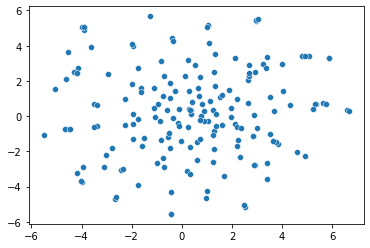

In [ ]:
# Using TSNE for data vizualization
tsne = TSNE(n_components= 2, learning_rate= 'auto', init= 'random')
X_cv_tsne= tsne.fit_transform(X_cv)
sns.scatterplot(x= X_cv_tsne[:,0], y= X_cv_tsne[:,1])

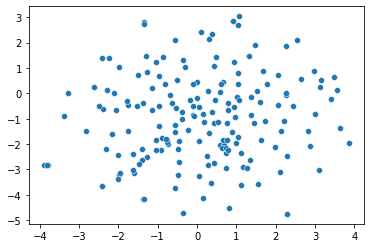

In [ ]:
X_cvb_tsne= tsne.fit_transform(X_cvb)
sns.scatterplot(x= X_cvb_tsne[:,0], y= X_cvb_tsne[:,1])

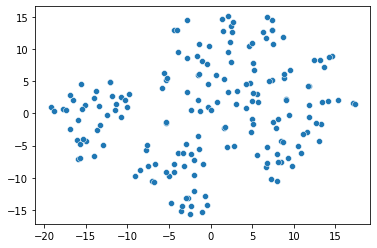

In [ ]:
X_tfidf_tsne= tsne.fit_transform(X_tfidf)
sns.scatterplot(x= X_tfidf_tsne[:,0], y= X_tfidf_tsne[:,1])

In X_tfidf_tsne dataframe better cluster patters can be seen.

# Model Building

## 1. Truncated SVD and KMeans with k-means++ initialization

In [ ]:
# Performing KMeans clustering on Binary vectorized data
kmeans= KMeans(n_clusters= 5, init= 'k-means++', random_state= 42)
labels_cvb= kmeans.fit_predict(X_cvb_t)

# Performing KMeans clustering on Count vectorized data
labels_cv= kmeans.fit_predict(X_cv_t)

# Performing KMeans clustering on Tfidf vectorized data
labels_tfidf= kmeans.fit_predict(X_tfidf_t)

In [ ]:
# Calculating silhouette score for different vectorized datasets
s_cvb= silhouette_score(X_cvb_t, labels_cvb, random_state= 42)
s_cv= silhouette_score(X_cv_t, labels_cv,  random_state= 42)
s_tfidf= silhouette_score(X_tfidf_t, labels_tfidf, random_state= 42)
print('Silhouette scores :\n')
print('Binary vectorization :',s_cvb)
print('Count vectorization :',s_cv)
print('Tfidf vectorization :', s_tfidf)

Silhouette scores :

Binary vectorization : 0.005829107444997306
Count vectorization : 0.2457672305249278
Tfidf vectorization : 0.048633560465262855


As we already know that we need to create 5 clusters (as we had 5 topics initially), we have kept n_clusters= 5 fixed. Silhouette scores is not good for any of these 3 models.

## 2. Truncated SVD and Hierarchical Clustering

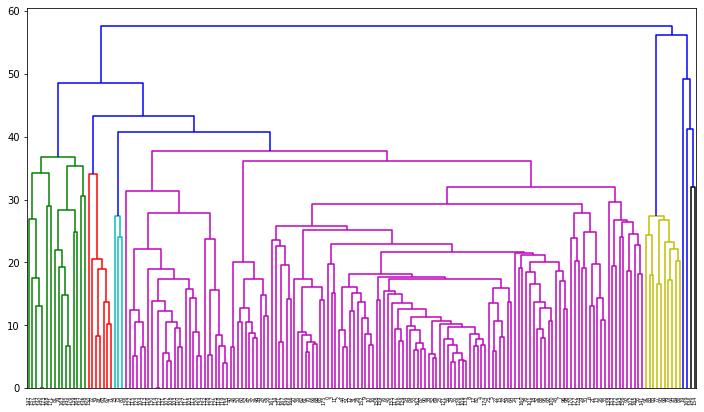

In [ ]:
# Hierarchical clustering on Count vectorized data
linked= linkage(X_cv_t, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
b1= cut_tree(linked, n_clusters= 5)
print('silhouette score of Count Vectorized data:', silhouette_score(X_cv_t, b1 , random_state= 42))

silhouette score of Count Vectorized data: 0.21851197006031628


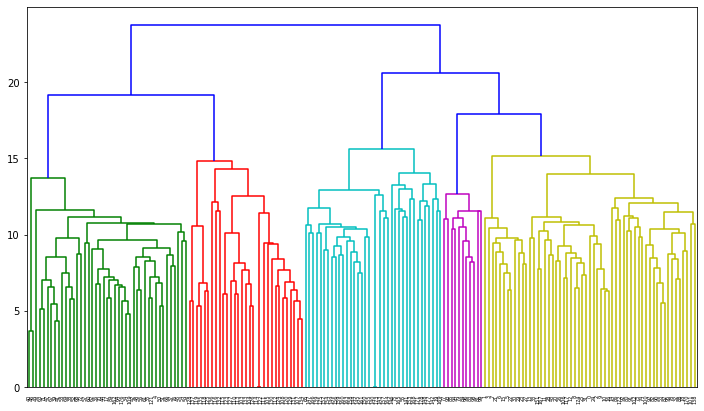

In [ ]:
# Hierarchical clustering Binary vectorized data
linked= linkage(X_cvb_t, 'ward')
plt.figure(figsize=(12, 7))
dendrogram(linked)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
b2= cut_tree(linked, n_clusters= 5)
print('silhouette score for Binary Vectorized data:', silhouette_score(X_cvb_t, b2 , random_state= 42))

silhouette score for Binary Vectorized data: -0.008543949417091167


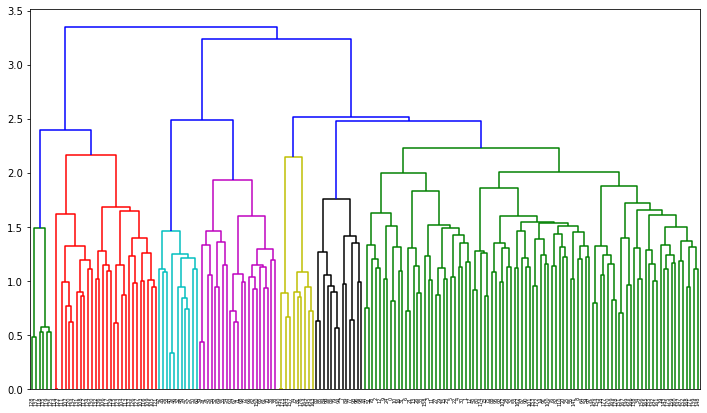

In [ ]:
# Hierarchical clustering on tfidf vectorized data
linked= linkage(X_tfidf_t, 'ward')
plt.figure(figsize=(12, 7))
dendrogram(linked)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
b3= cut_tree(linked, n_clusters= 5)
print('silhouette score for TF-IDF Vectorized data:', silhouette_score(X_tfidf_t, b3, random_state= 42))

silhouette score for TF-IDF Vectorized data: 0.048185028141882164


Using Hierarchical clustering we can not see any good cluster formation for truncated SVD data. The resutl is almost what we have seen in KMeans clustering.

## 3. tSNE and KMeans with k-means++ initialization

In [ ]:
# Using TSNE + KMeans
kmeans= KMeans(n_clusters= 5, init= 'k-means++', random_state= 42)
tfidf_tsne_labels= kmeans.fit_predict(X_tfidf_tsne)
cv_tsne_labels= kmeans.fit_predict(X_cv_tsne)
cvb_tsne_labels= kmeans.fit_predict(X_cvb_tsne)

In [ ]:
# Calculating silhouette score for different vectorized datasets
s_cvb= silhouette_score(X_cvb_tsne, cvb_tsne_labels, random_state= 42)
s_cv= silhouette_score(X_cv_tsne, cv_tsne_labels,  random_state= 42)
s_tfidf= silhouette_score(X_tfidf_tsne, tfidf_tsne_labels, random_state= 42)
print('Silhouette scores :\n')
print('Binary vectorization :',s_cvb)
print('Count vectorization :',s_cv)
print('Tfidf vectorization :', s_tfidf)

Silhouette scores :

Binary vectorization : 0.3461568
Count vectorization : 0.35106263
Tfidf vectorization : 0.44082624


## 4. tSNE and Hierarchical Clustering

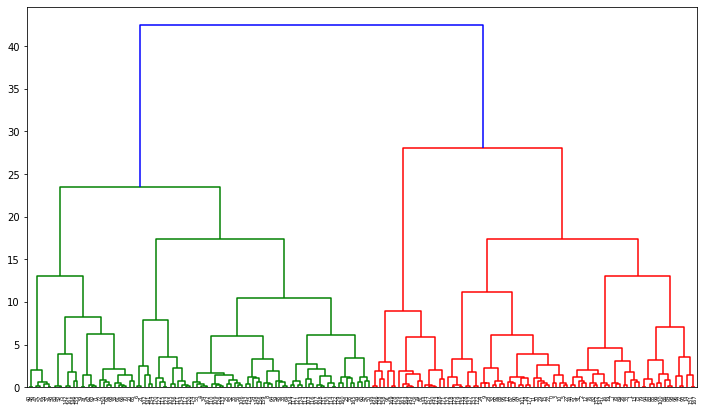

In [ ]:
# Hierarchical clustering on Count vectorized data
linked1= linkage(X_cv_tsne, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked1)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
c1= cut_tree(linked1, n_clusters= 5)
print('silhouette score of Count Vectorized data:', silhouette_score(X_cv_tsne, c1 , random_state= 42))

silhouette score of Count Vectorized data: 0.2728779


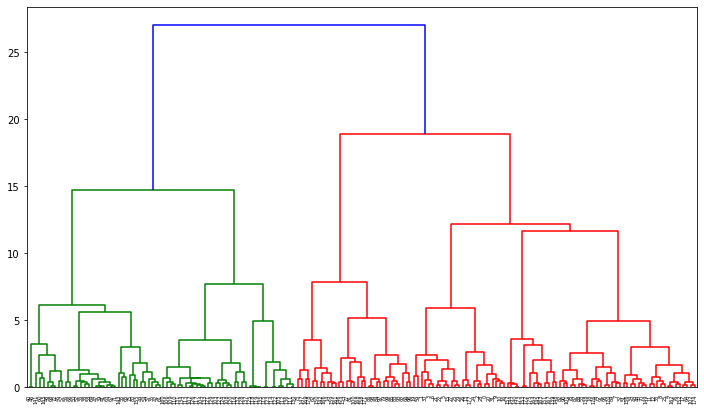

In [ ]:
# Hierarchical clustering Binary vectorized data
linked2= linkage(X_cvb_tsne, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked2)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
c2= cut_tree(linked2, n_clusters= 5)
print('silhouette score for Binary Vectorized data:', silhouette_score(X_cvb_tsne, c2 , random_state= 42))

silhouette score for Binary Vectorized data: 0.2976828


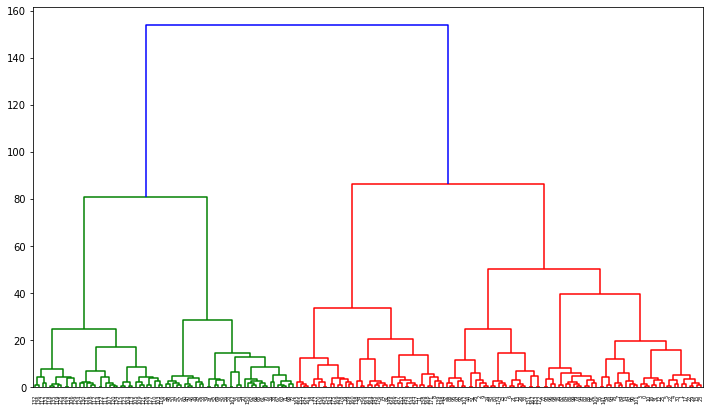

In [ ]:
# Hierarchical clustering on tfidf vectorized data
linked3= linkage(X_tfidf_tsne, 'ward', metric= 'euclidean')
plt.figure(figsize=(12, 7))
dendrogram(linked3)
plt.show()

In [ ]:
# silhouette score for n_clusters= 5
c3= cut_tree(linked3, n_clusters= 5)
print('silhouette score for TF-IDF Vectorized data:', silhouette_score(X_tfidf_tsne, c3 , random_state= 42))

silhouette score for TF-IDF Vectorized data: 0.426833


Here cluster formation is better for all different vectorized data. But tfidf vectorized data has best silhouette score for n_clusters= 5

# Plotting count of articles got from KMeans Clustering (on tfidf data)

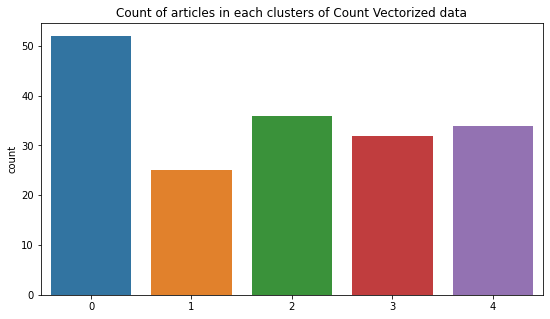

In [ ]:
# Plotting counts in each cluster
plt.figure(figsize=(9,5))
sns.countplot(cv_tsne_labels.ravel())
plt.title('Count of articles in each clusters of Count Vectorized data')
plt.show()

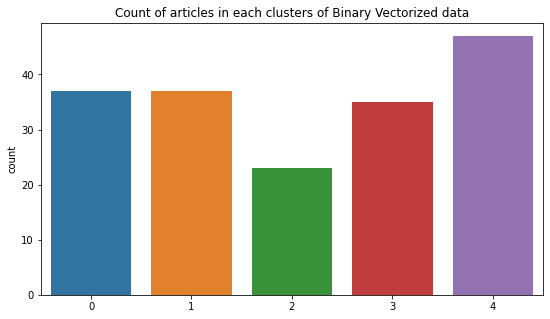

In [ ]:
# Plotting counts in each cluster
plt.figure(figsize=(9,5))
sns.countplot(cvb_tsne_labels.ravel())
plt.title('Count of articles in each clusters of Binary Vectorized data')
plt.show()

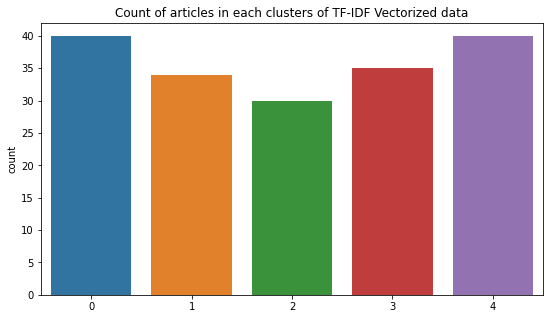

In [ ]:
# Plotting counts in each cluster
plt.figure(figsize=(9,5))
sns.countplot(tfidf_tsne_labels.ravel())
plt.title('Count of articles in each clusters of TF-IDF Vectorized data')
plt.show()

# Conclusion

### What does Silhouette Coefficient tell us?

---
Well formed clusters should have minimum within variance nad maximum between variance. Silhoutte coefficient is a measure of quality of clusters. It can be measure by using: 

(b(i) - a(i)) / max{b(i), a(i)}

b(i): for i-th datapoint distance from the nearest neighbour cluster (Separation)

a(i): for i-th data point distance from its own cluster (Cohesion). 

Final Silhoutte score is the average Silhoutte coefficient of all datapoints. Value of Silhoutte coefficient can be between -1 and 1. Closer the value to 1, means better clusters. 

Silhoutte coefficient can be used to find the optimal number of clusters in a dataset.



### Which algorithm to chose and why?

---
Here, KMeans and Hierarchical Clustering both have given almost same Silhoutte score for tfidf vectorized data with tSNE. KMeans clustering with k-means++ initialization has given slightly better result. So we can use either of these two clustering algorithms (with tfidf vectorized data with tSNE).

### Appropriate name to a cluster label?
---

In [ ]:
# Using labels got from KMeans clustering on tfidf vectorized dataset
labels= tfidf_tsne_labels.ravel()
df_new= df.merge(pd.Series(labels, name='label'), left_index= True, right_index=True)

# word cloud function
def word_cloud(data):
  corpus= ' '.join(data)
  stopwords= set(STOPWORDS)
  return(WordCloud(stopwords= stopwords, max_words= 100, background_color= 'white').generate(corpus))

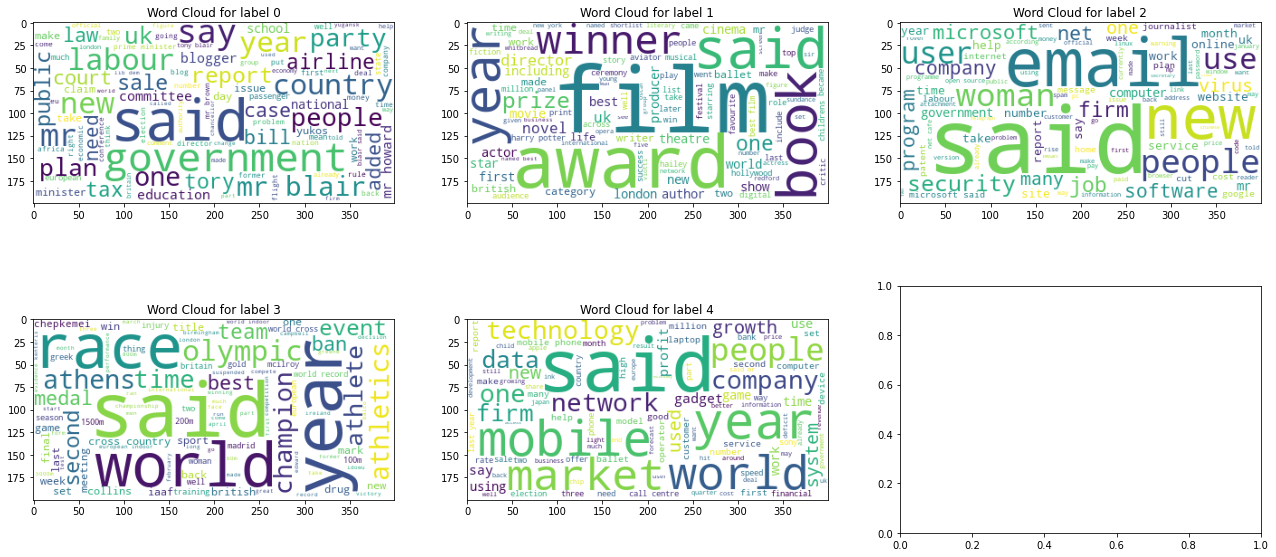

In [ ]:
# Plotting word cloud for all 5 labels

fig, axs= plt.subplots(2, 3, figsize=(22, 10))
for i in range(5):
  data= df_new[df_new.label== i].articles_preprocessed.values
  wc= word_cloud(data)
  j,k= i//3, i%3
  axs[j,k].imshow(wc)
  axs[j,k].set_title(f'Word Cloud for label {i}')
plt.show()

1. For label 0 government, tax, country, labour, party, public, education, law etc. words have appeared in word cloud, we can classify this cluster as : **Politics**

2. For label 1 film, award, actor, show, director, novel, book, producer etc. words have appeared in word cloud, we can classify this cluster as : **Entertainment**

3. For label 2 software, email, user, microsoft, job, security, firm, company, report etc. words have appeared in word cloud, we can classify this cluster as : **Business**

4. For label 3 olympic, medal, race, athens, event, athlete, team, finish,athletics etc. words have appeared in word cloud, we can classify this cluster as : **Sport**

5. For label 4  mobile, technology, game, gadget etc. words have appeared in word cloud, we can classify this cluster as : **Tech**

### Which vectorization technique is the best here and why?

---
Here TFIDF vectorization has given best result. 
Binary Vectorization replaces any non-zero frequency of count vectorizer with 1. So, in a record if a token appears one time or multiple times it represents both with 1. For an example: In a mobile review article (tech) 'mobile' can appear 10 times, whereas in a political article (document) 'mobile' may appear for only 1 time. But Binary Vectorization will set the value for 'mobile' term as 1 for both the articles. So Binary Vectorization could not capture here the feature representations properly.
Count Vectorizer captures frequency of all tokens in every document. Where FIDF vectorizer (TFIDF= term frequency * inverse document frequency) penalize or redices statistical significance of the terms which are too rare or available plenty in the corpus. So FIDF generally produces better vectorized represenattion in compared to count vectorization.
Though TFIDF gives a good understanding about the importance of words, but none of these can retain linguistic relationship between the tokens. Word2Vec, Glove word embedding techniques can be used to vectorize words keeping linguistic relations between them.

